# CONVOLUTIONAL NEURAL NETWORK FROM SCRATCH

## Import libraries

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import matplotlib.image as mpimg
from scipy.io import loadmat
import numpy as np
import tarfile
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import multiprocessing
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading and preprocessing data

In [20]:
# main paths
base_path = "/content/drive/My Drive/AML_progetto_2024-2025"
tgz_file_path = os.path.join(base_path, "102flowers.tgz")
extracted_images_dir = "/content/flowers/jpg"

# Function to extract the .tgz archive while avoiding the creation of unnecessary subfolders
def extract_tgz_file(tgz_path, extract_path):
    if not os.path.exists(extract_path):
        print(f"Extracting {tgz_path}...")
        with tarfile.open(tgz_path, "r:gz") as tar:
            def is_within_directory(directory, target):
                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)
                prefix = os.path.commonprefix([abs_directory, abs_target])
                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):
                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")
                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=extract_path)
        print(f"Extraction completed. Files are in {extract_path}.")
    else:
        print(f"Directory {extract_path} already exists. Skipping extraction.")

# File extraction (if necessary)
extract_tgz_file(tgz_file_path, "/content/flowers")

# Verify if files are extracted from the correct position
if not os.path.exists(extracted_images_dir):
    raise FileNotFoundError(f"Images not found in {extracted_images_dir}. Check extraction path.")

# Loading labels from file .mat
matlab_labels = loadmat(os.path.join(base_path, "imagelabels.mat"))
image_labels = matlab_labels['labels'][0]  # conversion to 0-based index

# Creating the DataFrame with files and categories
image_files = sorted([f for f in os.listdir(extracted_images_dir) if f.endswith(".jpg") or f.endswith(".jpeg")])

if len(image_files) != len(image_labels):
    raise ValueError(f"Mismatch between number of images ({len(image_files)}) and labels ({len(image_labels)}).")

labels_df = pd.DataFrame({
    'Image': image_files,
    'Category': image_labels[:len(image_files)]
})

Directory /content/flowers already exists. Skipping extraction.


In [21]:
# Image paths and labels
image_paths = labels_df['Image'].apply(lambda x: os.path.join(extracted_images_dir, x)).values
labels = labels_df['Category'].values - 1  # conversion to 0-based index

# number of classes
num_classes = len(np.unique(labels))

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))


In [22]:
#Loads an image, resizes it to 224x224, normalizes pixel values to [0,1], and applies one-hot encoding to the label for model training.

def preprocess_image(image_path, label):
    # Load and resize the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # decode JPEG format
    image = tf.image.resize(image, [224, 224])  # resize
    image = image / 255.0  # normalize between 0 e 1

    # One-hot encoding
    label = tf.one_hot(label, depth=num_classes)

    return image, label


**TRAIN SET**: 28 images were chosen for each class to balance the train set: this number corresponds to the 70% of the images of the least represented class

**TEST and VALIDATION SET**: the remaining images were equally split between the test and validation sets.

In [23]:
# Number of images for each class
train_per_class = 28

# Create lists for each split of the dataset
train_list = []
val_list = []
test_list = []

# Group by category
for category, group in labels_df.groupby("Category"):
    # Shuffle the class images
    group = group.sample(frac=1, random_state=42).reset_index(drop=True)

    # 28 images for the train
    train_list.append(group[:train_per_class])

    # Split the remaining data equally between validation and test sets
    remaining = group[train_per_class:]
    val_size = len(remaining) // 2

    val_list.append(remaining[:val_size])
    test_list.append(remaining[val_size:])

# Concat lists
train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")


Train set: 2856 images
Validation set: 2642 images
Test set: 2691 images


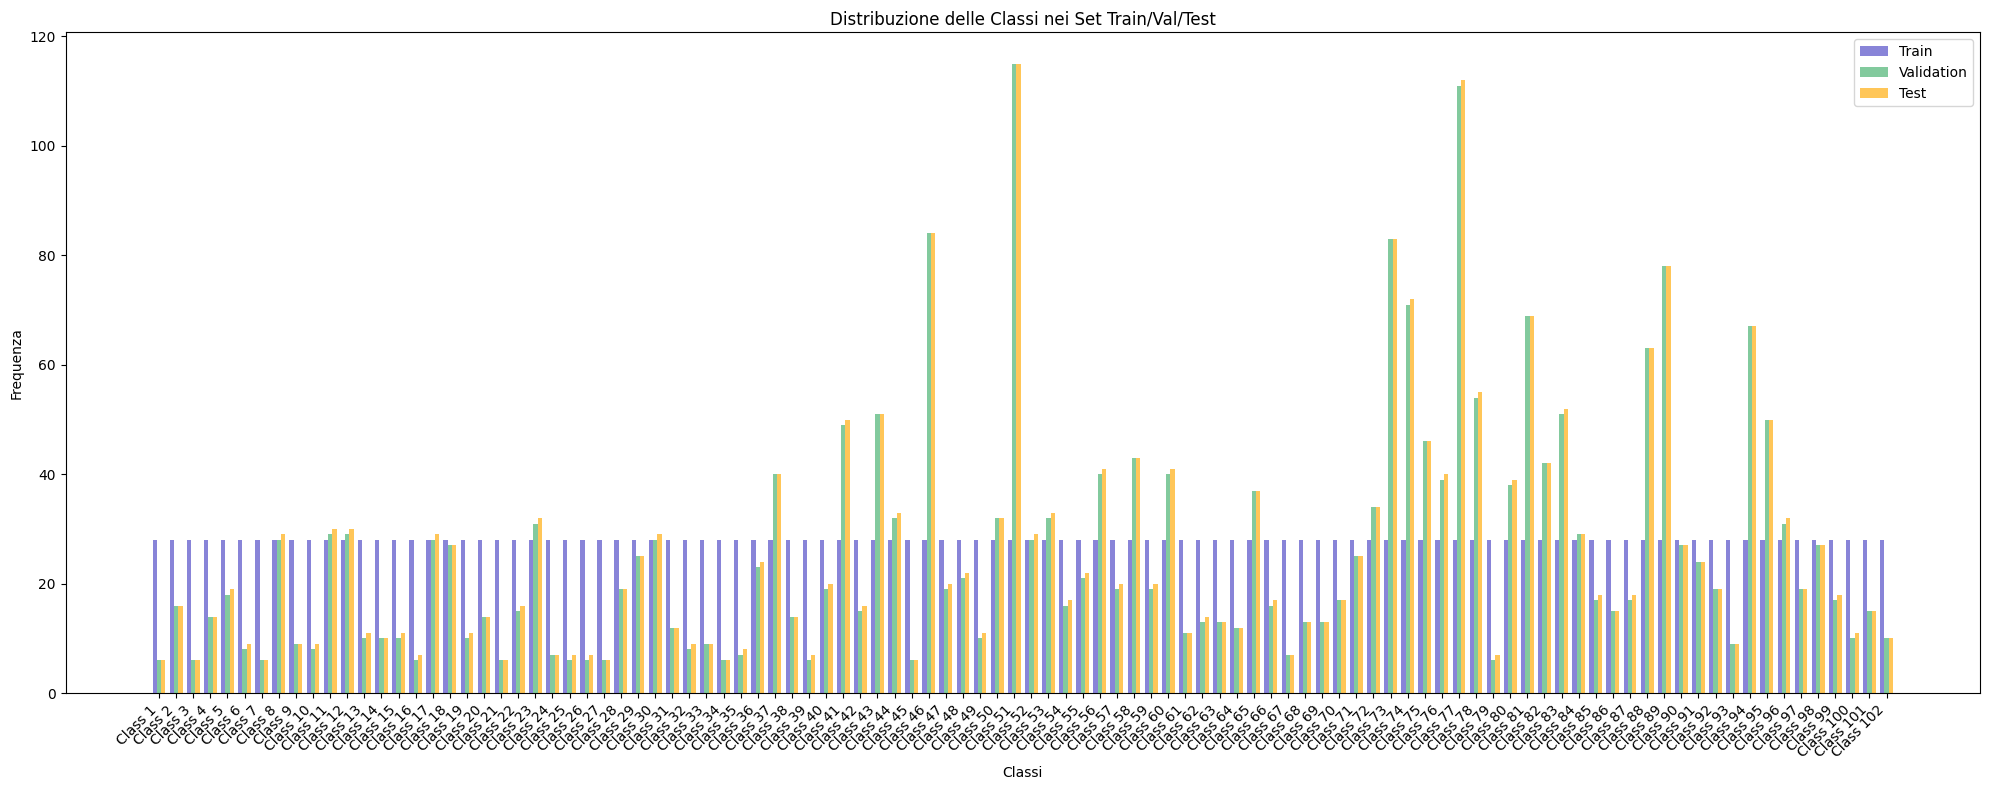

In [24]:
# Create the graph
plt.figure(figsize=(20, 8))  # Aumenta la larghezza per maggiore spazio
x = np.arange(num_classes)
width = 0.25

plt.bar(x - width, train_freq, width, label='Train', color='#8884d8')
plt.bar(x, val_freq, width, label='Validation', color='#82ca9d')
plt.bar(x + width, test_freq, width, label='Test', color='#ffc658')

plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nei Set Train/Val/Test')

# Migliora la leggibilità delle etichette dell'asse X
plt.xticks(
    x,
    [f'Class {i+1}' for i in range(num_classes)],  # Etichette per ogni classe
    rotation=45,  # Rotazione di 45 gradi
    fontsize=10,  # Dimensione del font
    ha='right'  # Allinea le etichette a destra
)

plt.legend()
plt.tight_layout()  # Riduce i margini extra
plt.show()


The conversion from a DataFrame to a TensorFlow dataset is particularly efficient because it enables greater efficiency and scalability (using batches) while ensuring seamless integration and optimization with GPUs

In [25]:
# Convert DataFrames into arrays of paths and labels

def df_to_dataset(df, batch_size=32, shuffle=True):
    image_paths = df["Image"].apply(lambda x: os.path.join(extracted_images_dir, x)).values
    labels = df["Category"].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [26]:
# create datasets

#A batch size of 32 achieves a balance between memory efficiency, gradient estimation, and convergence speed
batch_size = 32
train_ds = df_to_dataset(train_df, batch_size=batch_size, shuffle=True)
val_ds = df_to_dataset(val_df, batch_size=batch_size, shuffle=False)
test_ds = df_to_dataset(test_df, batch_size=batch_size, shuffle=True)

This particular test set is designed to evaluate the performance of the model using an equal number of samples for each class. The basic test set is composed of a high number of samples of the most represented classes, making it difficult to fairly evaluate performance across all classes

In [27]:
#create a test set with 6 images for each class
im_per_class = 6
test_list_equalsize = []

for category, group in test_df.groupby("Category"):
    selected_images = group.sample(n=im_per_class, random_state=42)
    test_list_equalsize.append(selected_images)

test_df_equalsize = pd.concat(test_list_equalsize).reset_index(drop=True)

print(f"New equal-sized test set: {len(test_df_equalsize)} images")

New equal-sized test set: 612 images


In [28]:
# Ensure that each category has exactly 6 images
print(test_df_equalsize.groupby("Category").size())

# Verify some rows to ensure that labels are correct
print(test_df_equalsize[12:32])

#create the dataset for the equal-sized test set:
test_ds_equalsize = df_to_dataset(test_df_equalsize, batch_size=batch_size, shuffle=True)

Category
1      6
2      6
3      6
4      6
5      6
      ..
98     6
99     6
100    6
101    6
102    6
Length: 102, dtype: int64
              Image  Category
12  image_06630.jpg         3
13  image_06632.jpg         3
14  image_06650.jpg         3
15  image_06619.jpg         3
16  image_06640.jpg         3
17  image_06626.jpg         3
18  image_05671.jpg         4
19  image_05657.jpg         4
20  image_05664.jpg         4
21  image_05680.jpg         4
22  image_05647.jpg         4
23  image_05636.jpg         4
24  image_05148.jpg         5
25  image_05182.jpg         5
26  image_05204.jpg         5
27  image_05168.jpg         5
28  image_05157.jpg         5
29  image_05161.jpg         5
30  image_07190.jpg         6
31  image_07184.jpg         6


These sets follow a different approach: there were designed to be composed of a standard split: 70% for train, 15% for validation and 15% for test.
This might be a problem for the model, as it could bias the network to better recognize the most represented classes

In [29]:
#Create unbalanced sets

train_list = []
val_list = []
test_list = []

# Group by category
for category, group in labels_df.groupby("Category"):
    # Shuffle the class images
    group = group.sample(frac=1, random_state=42).reset_index(drop=True)

    index = int(len(group) * 70 / 100)

    # 28 images for the train
    train_list.append(group[:index])

    # Split the remaining data equally between validation and test sets
    remaining = group[train_per_class:]
    val_size = len(remaining) // 2

    val_list.append(remaining[:val_size])
    test_list.append(remaining[val_size:])

# Concat lists
train_df_unbalanced = pd.concat(train_list).reset_index(drop=True)
val_df_unbalanced = pd.concat(val_list).reset_index(drop=True)
test_df_unbalanced = pd.concat(test_list).reset_index(drop=True)

print(f"Train set: {len(train_df_unbalanced)} immagini")
print(f"Validation set: {len(val_df_unbalanced)} immagini")
print(f"Test set: {len(test_df_unbalanced)} immagini")

Train set: 5687 immagini
Validation set: 2642 immagini
Test set: 2691 immagini


In [30]:
# create unbalanced datasets
batch_size = 32
train_ds_unbalanced = df_to_dataset(train_df_unbalanced, batch_size=batch_size, shuffle=True)
val_ds_unbalanced = df_to_dataset(val_df_unbalanced, batch_size=batch_size, shuffle=False)
test_ds_unbalanced = df_to_dataset(test_df_unbalanced, batch_size=batch_size, shuffle=False)

## Data Augmentation on training data

Data augmentation is a technique applied to the training set to enhance the model's ability to recognize patterns and generalize better. It involves generating new samples for the training set by creating modified versions of the existing images through various transformations: in this case two images were generated for each sample using a combination of the following transformations:


*   Horizontal flipping
*   Random brightness adjustment
*   Contrast variation
*   Random 90 degree rotation



In [31]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

#Apply random augmentations using tf.image operations
def augment_image(image):
    #Apply random augmentations using tf.image operations
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random brightness
    image = tf.image.random_brightness(image, 0.2)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Ensure values stay in [0, 1] range
    image = tf.clip_by_value(image, 0, 1)

    return image

def preprocess_image(image_path, label):
    """Basic preprocessing without augmentation"""
    # Load and resize image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize

    # One-hot encoding
    label = tf.one_hot(label, depth=num_classes)

    return image, label

def create_augmented_dataset(df, batch_size=32, shuffle=True, augmentations_per_image=3):
    """Creates a dataset with augmented images using tf.data pipeline"""
    image_paths = df["Image"].apply(lambda x: os.path.join(extracted_images_dir, x)).values
    labels = df["Category"].values

    # Create base dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Apply preprocessing
    dataset = dataset.map(preprocess_image,
                         num_parallel_calls=tf.data.AUTOTUNE)

    # Create multiple versions of the dataset for augmentation
    datasets = [dataset]  # Start with original dataset

    # Create augmented versions
    for _ in range(augmentations_per_image):
        augmented_dataset = dataset.map(
            lambda x, y: (augment_image(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        datasets.append(augmented_dataset)

    # Combine all datasets
    final_dataset = datasets[0]
    for ds in datasets[1:]:
        final_dataset = final_dataset.concatenate(ds)

    if shuffle:
        final_dataset = final_dataset.shuffle(buffer_size=1000)

    return final_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [32]:
# Create the datasets
batch_size = 32

# Use augmentation only for training set
train_ds_augm = create_augmented_dataset(train_df,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  augmentations_per_image=2)


# Calculate and print dataset sizes
num_train_original = len(train_df)
num_train_augmented = num_train_original * 3  # Original + 3 augmentations
print(f"Original training images: {num_train_original}")
print(f"Augmented training images: {num_train_augmented}")
print(f"Validation images: {len(val_df)}")
print(f"Test images: {len(test_df)}")

Original training images: 2856
Augmented training images: 8568
Validation images: 2642
Test images: 2691


In [33]:
#Clearing unnecessary DataFrames from RAM before training to prevent memory errors
import gc
del labels_df, train_df, val_df, test_df , test_df_equalsize , test_df_unbalanced, train_df_unbalanced , val_df_unbalanced
gc.collect()

29920

## CNN 1
The first network consists of 4 convolutional blocks, each with a single Conv2D layer (3x3 kernels) and a progressive increase in the number of filters (32, 64, 128, 256). Each block includes batch normalization, a 2x2 max pooling layer, and dropout layers (rates: 0.3–0.4) to reduce overfitting.

The network uses a global average pooling layer after the convolutional blocks to reduce spatial dimensions and avoid overfitting caused by flattening large feature maps. Following this, a 128-unit dense layer with ReLU activation and L2 regularization (alpha=0.01) is applied, followed by a dropout layer (rate: 0.5). The final output layer uses a softmax activation to classify the input into 102 flower categories.

To ensure smooth convergence and minimize overfitting, the model is compiled with the Adam optimizer at a reduced learning rate of 0.0003. Additionally, ReduceLROnPlateau is used as a callback to dynamically reduce the learning rate when the validation loss plateaus, improving generalization.

In [1]:
# Method to create graphs and to save them in pdf format

def plot_history(history , networkName):
    plt.figure(figsize=(12, 6))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    #plt.savefig(networkName);
    plt.savefig(f"{networkName}.pdf", format='pdf', dpi=300, bbox_inches='tight')

    plt.show()


In [38]:
#method to create confusion matrix

def plot_cm(test_ds, model):
  y_true, y_pred = [], []
  for images, labels in test_ds:
      preds = model.predict(images)
      y_true.extend(np.argmax(labels.numpy(), axis=1))
      y_pred.extend(np.argmax(preds, axis=1))
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  # Generate Confusion Matrix
  unique_classes = np.unique(y_true.tolist() + y_pred.tolist())
  cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
  # Normalize the confusion matrix
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  # Plot Confusion Matrix
  plt.figure(figsize=(14, 10))
  sns.heatmap(cm_normalized, annot=False, cmap="coolwarm", cbar=True, xticklabels=unique_classes, yticklabels=unique_classes)
  plt.xlabel("Predicted Class", fontsize=14)
  plt.ylabel("True Class", fontsize=14)
  plt.title("Normalized Confusion Matrix - Model Reg Aug 3", fontsize=16)
  plt.xticks(rotation=90, fontsize=10)
  plt.yticks(fontsize=10)
  plt.tight_layout()
  plt.savefig("confusion_matrix_model_reg_aug_3.pdf")
  plt.show()



In [ ]:
# method for creating the model

def create_improved_flower_cnn(input_shape=(224, 224, 3), num_classes=102):
    """
    Improved CNN for flower classification:
    - Reduced parameters in Dense layers to prevent overfitting
    - Increased Dropout and L2 regularization
    - GlobalAveragePooling to reduce Flatten-related overfitting
    - Lower initial learning rate for finer weight updates
    """
    model = models.Sequential([
        # First conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      input_shape=input_shape,
                      kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Second conv block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Third conv block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Fourth conv block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Global Average Pooling layer
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model with reduced learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Updated callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        min_delta=0.0005
    )
]


### CNN 1 - no data augm - balanced training

In [ ]:
# Create the model
model = create_improved_flower_cnn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             5

 Total params: 436,902 (1.67 MB)

 Trainable params: 435,686 (1.66 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
history= model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,  # Early stopping will prevent all epochs from running
    callbacks=callbacks)

Epoch 1/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 278ms/step - accuracy: 0.0170 - loss: 9.7420 - val_accuracy: 0.0023 - val_loss: 9.1671 - learning_rate: 3.0000e-04
Epoch 2/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.0504 - loss: 8.8130 - val_accuracy: 0.0140 - val_loss: 9.0515 - learning_rate: 3.0000e-04
Epoch 3/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.0691 - loss: 8.2538 - val_accuracy: 0.0144 - val_loss: 8.9964 - learning_rate: 3.0000e-04
Epoch 4/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.0898 - loss: 7.7490 - val_accuracy: 0.0167 - val_loss: 9.1963 - learning_rate: 3.0000e-04
Epoch 5/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.1119 - loss: 7.3146 - val_accuracy: 0.0223 - val_loss: 8.5905 - learning_rate: 3.0000e-04
Epoch 6/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.1407 - loss: 6.8850 - val_accuracy: 0.0242 - val_loss: 8.0749 - learning_rate: 3.0000e-04
Epoch 7/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - acc

#### Saving the parameters of the trained model

In [ ]:
#  Salvataggio del modello
model.save("model_CNN1noDA_oxford102.h5")

#### Plotting train and validation accuracy/loss

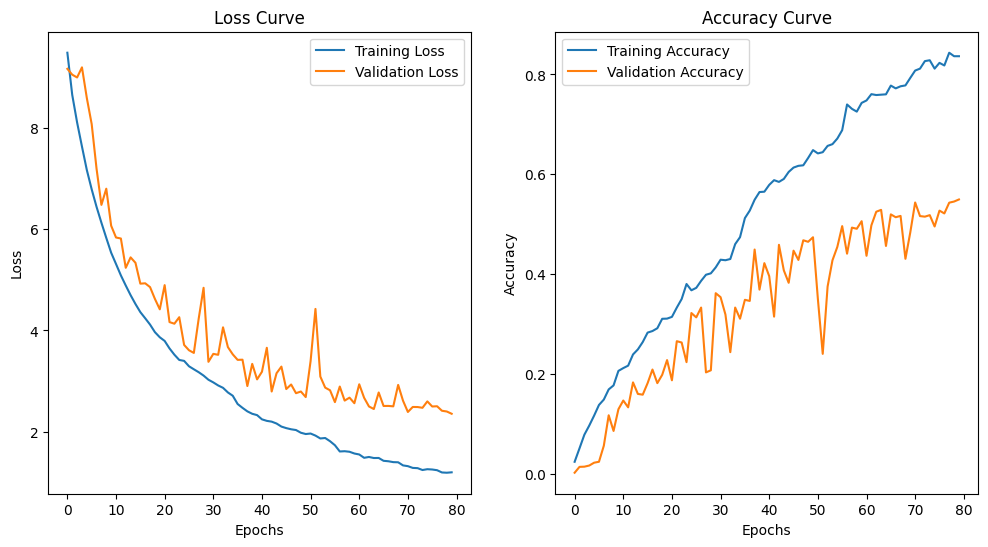

In [ ]:
plot_history(history , "model_CNN1noDA" )

**Loss**: the curve of the loss indicates that on the training set there is a quite constant decrease, but the validation loss is much more irregular, stabilizing its decline on the last epochs.
These differences suggest that the model suffers from overfitting.

**Accuracy**: The differences in accuracy between the training and validation sets are very similar to the behavior of the loss curves. The gap in the final accuracy scores indicates that the model is affected by overfitting

#### Confusion matrix

In [39]:
#model = tf.keras.models.load_model('model_CNN1noDA_oxford102.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━

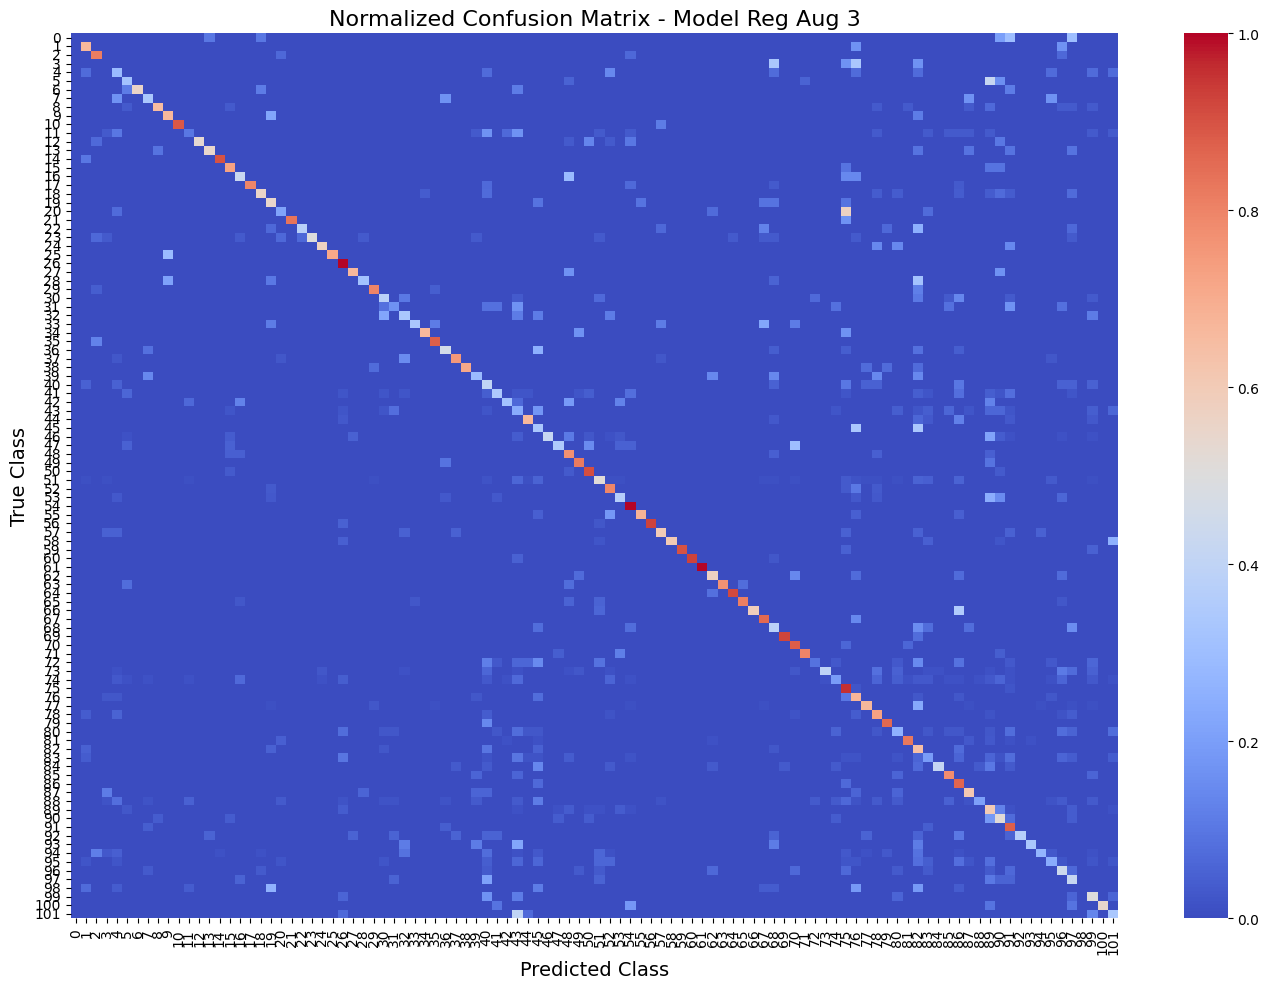

In [40]:
plot_cm(test_ds , model)

#### Calculating accuracy on test set and balanced test set

In [ ]:
# Calculate the accuracy on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.5498 - loss: 2.3372
Test Accuracy: 53.77%
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.5721 - loss: 2.2221
Test Accuracy (on balanced test set): 55.07%


### CNN 1 from scratch - with data augm

In [ ]:
#callbacks

callbacks_augm = [
    #early stopping: stops the training if the value of val_loss dosen't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=0.0005
    ),

    # Reduces the learning rate by a factor of 0.5 if val_loss does not improve for 5 consecutive epochs to avoid getting stuck in a local minimum.
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        min_delta=0.0005
    )
]

In [ ]:
#create the model
model1_augm = create_improved_flower_cnn()
model1_augm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             5

 Total params: 436,902 (1.67 MB)

 Trainable params: 435,686 (1.66 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
history_augm = model1_augm.fit(
    train_ds_augm,
    validation_data=val_ds,
    epochs=80,  # Early stopping will prevent all epochs from running
    callbacks=callbacks_augm)

Epoch 1/80
268/268 ━━━━━━━━━━━━━━━━━━━━ 64s 175ms/step - accuracy: 0.0315 - loss: 9.3804 - val_accuracy: 0.0193 - val_loss: 8.9848 - learning_rate: 3.0000e-04
Epoch 2/80
268/268 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.0882 - loss: 7.6783 - val_accuracy: 0.0681 - val_loss: 7.5211 - learning_rate: 3.0000e-04
Epoch 3/80
268/268 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.1167 - loss: 6.5933 - val_accuracy: 0.1060 - val_loss: 6.6384 - learning_rate: 3.0000e-04
Epoch 4/80
268/268 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - accuracy: 0.1495 - loss: 5.7239 - val_accuracy: 0.1113 - val_loss: 5.8043 - learning_rate: 3.0000e-04
Epoch 5/80
268/268 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.1978 - loss: 5.0326 - val_accuracy: 0.1620 - val_loss: 5.0621 - learning_rate: 3.0000e-04
Epoch 6/80
268/268 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.2372 - loss: 4.5108 - val_accuracy: 0.2214 - val_loss: 4.5665 - learning_rate: 3.0000e-04
Epoch 7/80
268/268 ━━━━━━━━━━━━━━━━━━━━ 35s 12

#### Saving the parameters of the trained model

In [ ]:
#save the model
model1_augm.save("model_CNN1_augm_oxford102.h5")

#### Plotting train and validation accuracy/loss

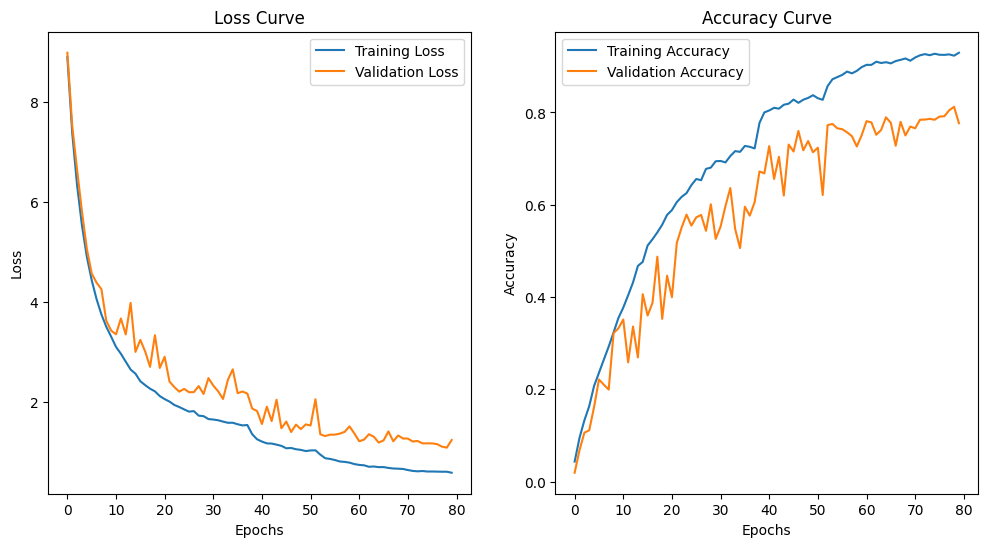

In [ ]:
plot_history(history_augm, "model_CNN1_augm")

**Loss**: the loss curves show significant improvement in performance compared to the model without data augmentation.
The two curves are closer to each other, even though the validation curve appears slightly irregular

**Accuracy**: The accuracy curve on the training set indicates that the model learns effectively, as it shows a fairly constant increase. The curve on the validation set demonstrates a good improvement compared to the validation accuracy of the previous model, although it still shows some irregularities.

The performance on this model with data augmentation is better than the previous model, the accuracy score on validation and train is higher than before, but the gap between the two scores indicates that the model still suffers from overfitting

#### Confusion matrix

In [41]:
#model1_augm = tf.keras.models.load_model('model_CNN1_augm_oxford102.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

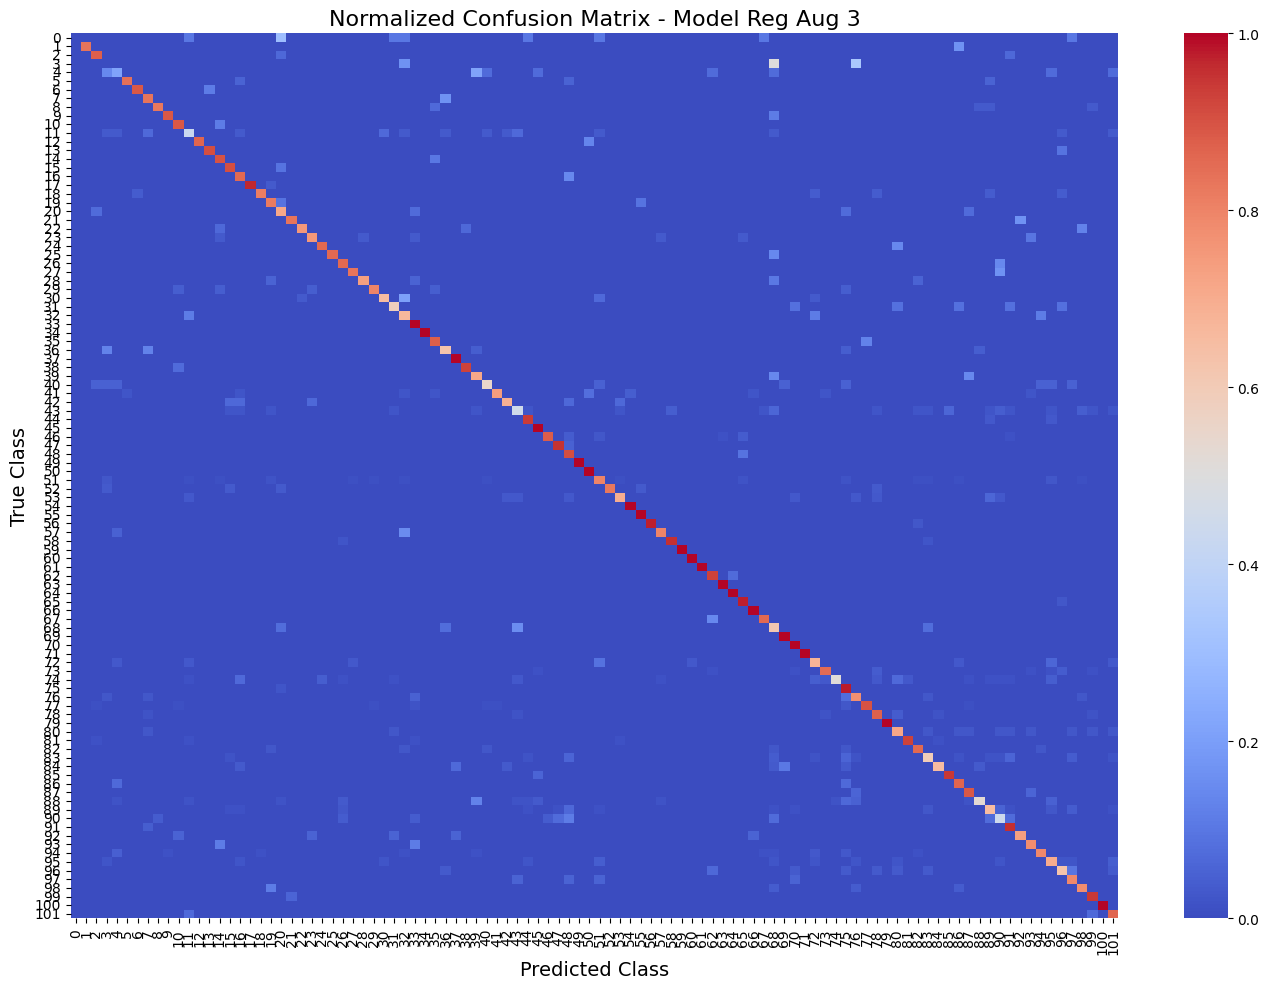

In [42]:
plot_cm(test_ds , model1_augm)

#### Calculating accuracy on test set and balanced test set

In [ ]:
# Calculate the accuracy on test set
test_loss, test_accuracy = model1_augm.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model1_augm.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8002 - loss: 1.0842
Test Accuracy: 80.01%
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7835 - loss: 1.1034
Test Accuracy (on balanced test set): 80.07%


## CNN 2

The improved network consists of 3 convolutional blocks, each with two Conv2D layers (3x3 kernels) and a progressive increase in filters (16, 32, 64). Each block includes batch normalization, 2x2 max pooling, and spatial dropout (rate: 0.2) to prevent overfitting.

After the convolutional blocks, a global average pooling layer reduces spatial dimensions, followed by a 64-unit dense layer with ReLU activation and a softmax output layer for classification into 102 flower categories.

Regularization techniques include L2 regularization (alpha=0.0001) and dropout layers. The model is trained using the Adam optimizer with a reduced learning rate of 0.001 for smoother convergence.

In [ ]:
#method for creating the model

def create_improved_flower_cnn_2(input_shape=(224, 224, 3), num_classes=102):
    """
    Further improved CNN for flower classification:
    - Reduced number of filters to prevent overfitting
    - Adjusted regularization parameters
    - Double Conv2D layers in each block for better feature extraction
    - Modified dropout rates and regularization strength
    """
    model = models.Sequential([
        # First conv block
        layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                      input_shape=input_shape,
                      kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.2),

        # Second conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.2),

        # Third conv block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.2),

        # Global Average Pooling layer
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model with further reduced learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### CNN 2 with data-augmentation

In [ ]:
# Create the model
model_CNN2 = create_improved_flower_cnn_2()
model_CNN2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 56, 56, 32)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_2                  │ (None, 28, 28, 64)          │              

 Total params: 84,022 (328.21 KB)

 Trainable params: 83,446 (325.96 KB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
history_augm_2 = model_CNN2.fit(
    train_ds_augm,
    validation_data=val_ds,
    epochs=100,  # Early stopping will prevent all epochs from running
    callbacks=callbacks_augm)

Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - accuracy: 0.0302 - loss: 4.6212 - val_accuracy: 0.0435 - val_loss: 4.4889 - learning_rate: 0.0010
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - accuracy: 0.0836 - loss: 3.9180 - val_accuracy: 0.1268 - val_loss: 3.5667 - learning_rate: 0.0010
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.1148 - loss: 3.6492 - val_accuracy: 0.1628 - val_loss: 3.3977 - learning_rate: 0.0010
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.1462 - loss: 3.4661 - val_accuracy: 0.1998 - val_loss: 3.2323 - learning_rate: 0.0010
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.1527 - loss: 3.3224 - val_accuracy: 0.2426 - val_loss: 3.0479 - learning_rate: 0.0010
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.1806 - loss: 3.1839 - val_accuracy: 0.2631 - val_loss: 2.9942 - learning_rate: 0.0010
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accura

#### Saving the parameters of the trained model

In [ ]:
# Save the model
model_CNN2.save("model_CNN2_augmented_oxford102.h5")

#### Plotting train and validation accuracy/loss



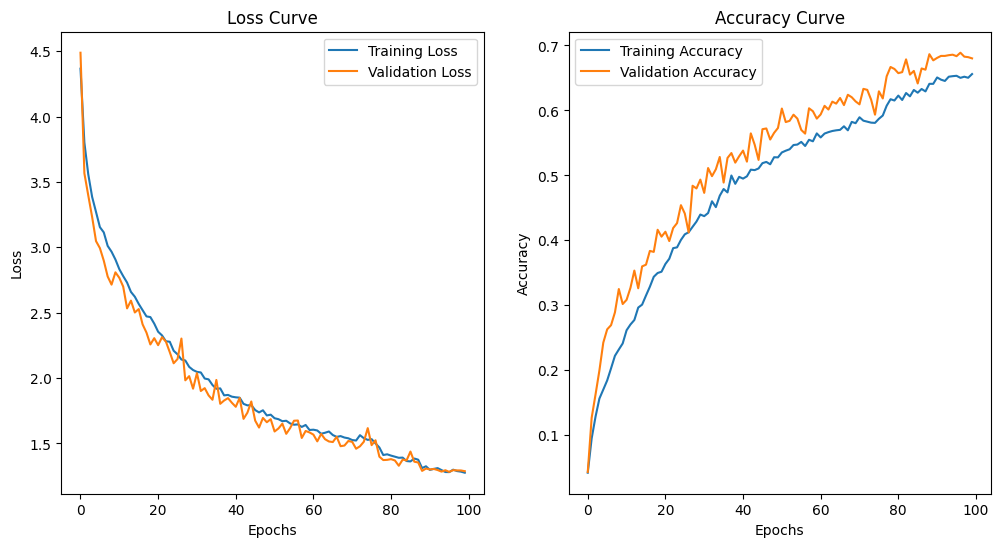

In [ ]:
plot_history(history_augm_2, "model_CNN2_augm")

**Loss**: the two curves of the loss functions are very similar, they decrease pretty constantly, that indicates that the model is learning from training data and its generalizing well

**Accuracy**: These two curves are very similar too. The training accuracy curve stays always under the validation curve, but it starts to get closer at the last epochs. This is a sign that there is a slight underfitting, but this problem can be solved with more additional training epochs.

The accuracy score is not very high, as neither curve reaches 70%.

#### Confusion matrix

In [47]:
#model_CNN2 = tf.keras.models.load_model("model_CNN2_augmented_oxford102.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1

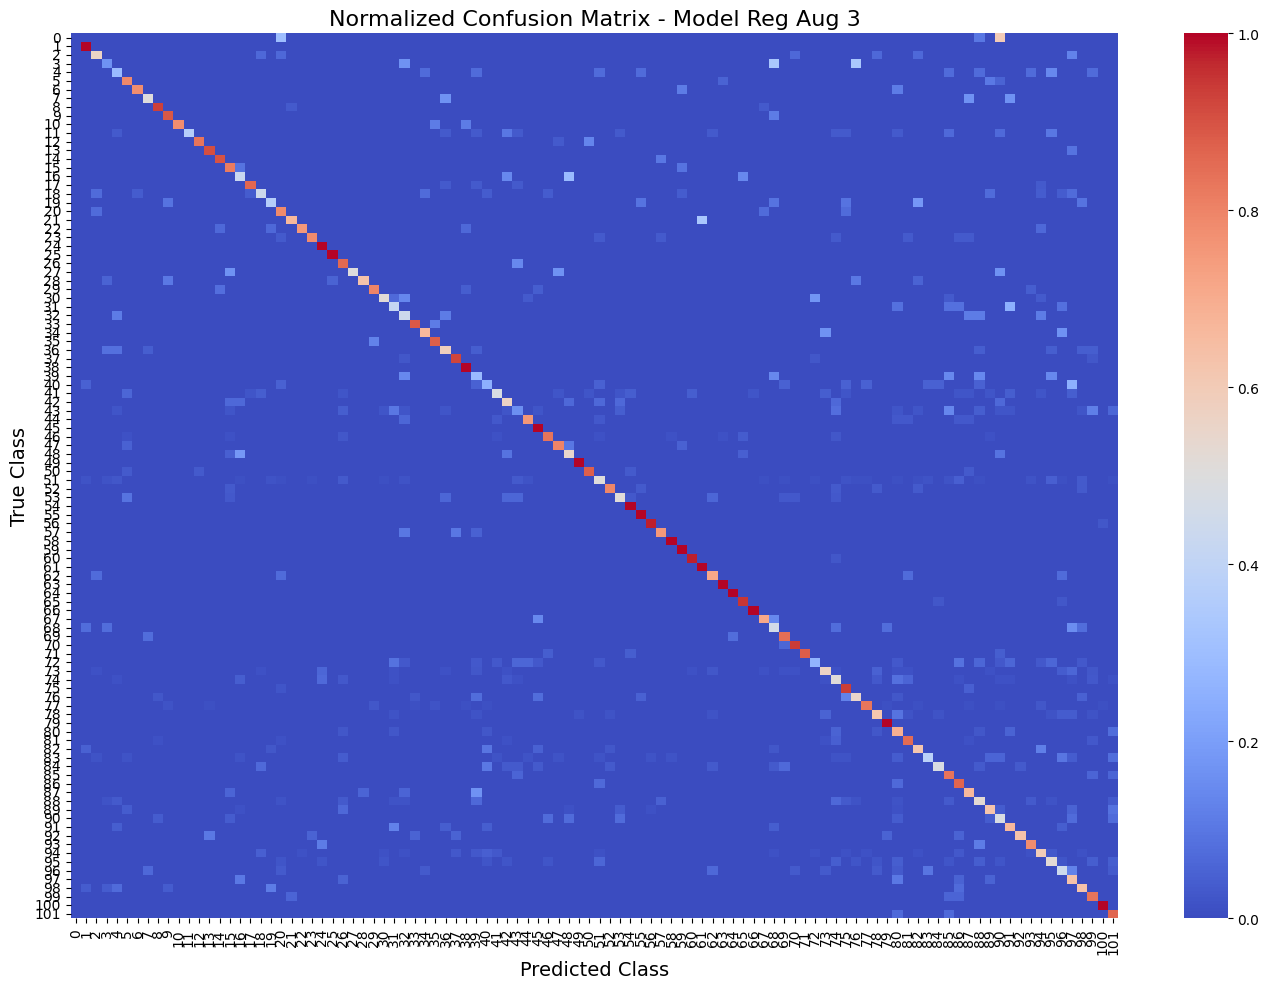

In [48]:
plot_cm(test_ds , model_CNN2)

#### Calculating accuracy on test set and balanced test set

In [ ]:
# Calcola l'accuracy sul test set
test_loss, test_accuracy = model_CNN2.evaluate(test_ds)  # test_ds è il tuo dataset di test
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model_CNN2.evaluate(test_ds_equalsize)  # test_ds è il tuo dataset di test
print(f"Test Accuracy: {test_accuracy_equalsize * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.6875 - loss: 1.2647
Test Accuracy: 68.19%
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.6934 - loss: 1.1880
Test Accuracy: 70.10%


### CNN 2 Without data-augmentation

In [ ]:
#definition of model 2 without data augmentation
model_CNN2_noDA = create_improved_flower_cnn_2()
model_CNN2_noDA.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 56, 56, 32)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_2                  │ (None, 28, 28, 64)          │              

 Total params: 84,022 (328.21 KB)

 Trainable params: 83,446 (325.96 KB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
history_CNN2_noDA = model_CNN2_noDA.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,  # Early stopping will prevent all epochs from running
    callbacks=callbacks_augm)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.0205 - loss: 4.8501 - val_accuracy: 0.0053 - val_loss: 4.6897 - learning_rate: 0.0010
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.0386 - loss: 4.3551 - val_accuracy: 0.0102 - val_loss: 4.6770 - learning_rate: 0.0010
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.0660 - loss: 4.1591 - val_accuracy: 0.0216 - val_loss: 4.5612 - learning_rate: 0.0010
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.0884 - loss: 3.9399 - val_accuracy: 0.0545 - val_loss: 4.1983 - learning_rate: 0.0010
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.0902 - loss: 3.8357 - val_accuracy: 0.1079 - val_loss: 3.7912 - learning_rate: 0.0010
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.1087 - loss: 3.7226 - val_accuracy: 0.1590 - val_loss: 3.5055 - learning_rate: 0.0010
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.1178 - l

#### Saving the parameters of the trained model

In [ ]:
#  Salvataggio del modello
model_CNN2_noDA.save("model_CNN2noDA_oxford102.h5")

#### Plotting train and validation accuracy/loss

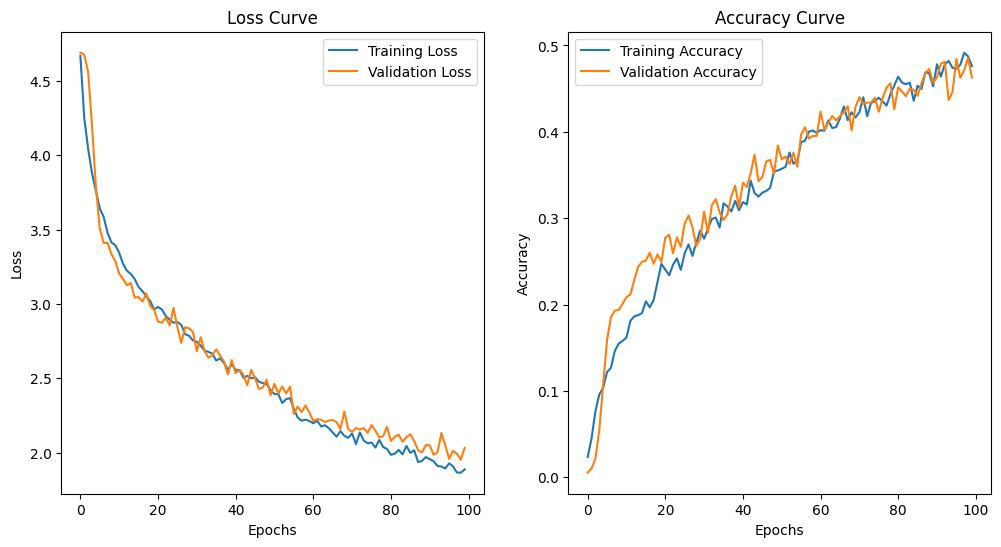

In [ ]:
plot_history(history_CNN2_noDA , "model_CNN2noDA")

**Loss**: the behaviour of the two loss functions is very similar to the previous model with data augmentation, but with some more variability.

**Accuracy**: the two accuracy curves are both irregular, but in this case there's not evidence of underfitting

The Accuracy score is lower than the previous model, not reaching 50%, that indicates that the data augmentation helps significantly this model to perform better.

#### Confusion matrix

In [43]:
#model_CNN2noDA = tf.keras.models.load_model('model_CNN2noDA_oxford102.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━

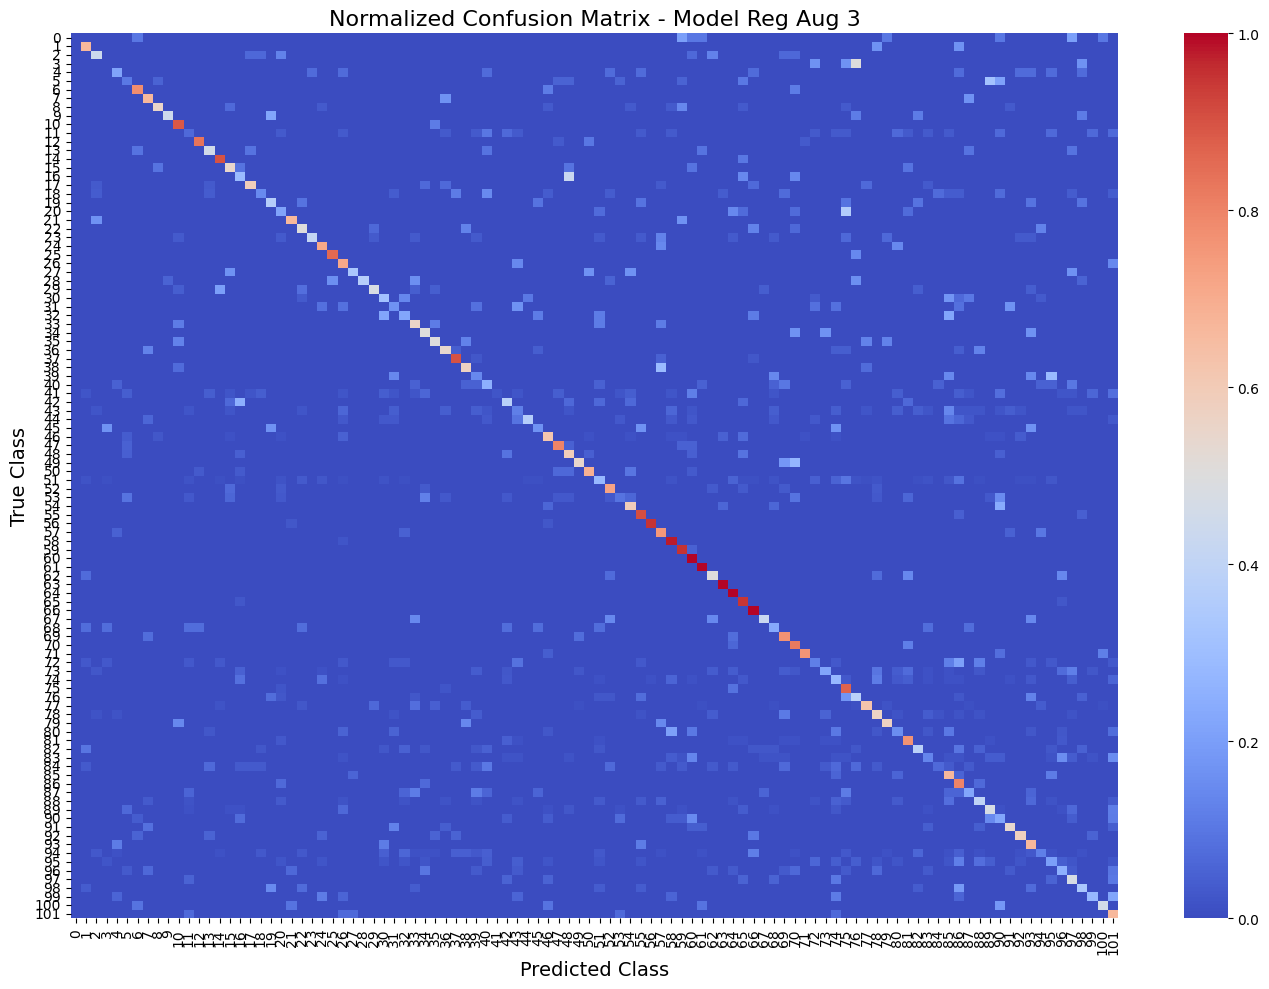

In [45]:
plot_cm(test_ds , model_CNN2noDA)

#### Calculating accuracy on test set and balanced test set

In [ ]:
# Calcola l'accuracy sul test set
test_loss, test_accuracy = model_CNN2_noDA.evaluate(test_ds)  # test_ds è il tuo dataset di test
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model_CNN2_noDA.evaluate(test_ds_equalsize)  # test_ds è il tuo dataset di test
print(f"Test Accuracy: {test_accuracy_equalsize * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.4961 - loss: 1.8806
Test Accuracy: 47.53%
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.4899 - loss: 1.9046
Test Accuracy: 48.04%


## CNN 3
The improved network consists of 4 convolutional blocks, each with a Conv2D layer (3x3 kernels) followed by a DepthwiseConv2D layer for efficient feature extraction. The number of filters increases progressively (32, 64, 128, 256) across blocks. Each block includes batch normalization, a 2x2 max pooling layer, and spatial dropout (rate: 0.3) to reduce overfitting. A global average pooling layer aggregates features, followed by a 128-unit dense layer with ReLU activation and a softmax output layer for classifying 102 flower categories. Regularization techniques include L2 regularization and dropout, while the model is optimized using the Adam optimizer with a learning rate of 0.0005.


### CCN 3 with data augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers

def create_improved_flower_cnn_3(input_shape=(224, 224, 3), num_classes=102):
    """
    Further improved CNN for flower classification:
    - Increased the number of filters in each convolutional block
    - Added more convolutional and max-pooling layers for better feature extraction
    - Utilized depthwise-separable convolutions for efficiency
    - Adjusted regularization parameters and dropout rates
    """
    model = models.Sequential([
        # First conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.DepthwiseConv2D((3, 3), activation='relu', padding='same',
                             depthwise_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),

        # Second conv block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.DepthwiseConv2D((3, 3), activation='relu', padding='same',
                             depthwise_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),

        # Third conv block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.DepthwiseConv2D((3, 3), activation='relu', padding='same',
                             depthwise_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),

        # Fourth conv block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.DepthwiseConv2D((3, 3), activation='relu', padding='same',
                             depthwise_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),

        # Global Average Pooling layer
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model with further reduced learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Create the model
model_CNN3 = create_improved_flower_cnn_3()
model_CNN3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 112, 112, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 56, 56, 64)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 56, 56, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_2                  │ (None, 28, 28, 128)         │              

 Total params: 443,622 (1.69 MB)

 Trainable params: 441,446 (1.68 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:
history_augm_CNN3 = model_CNN3.fit(
    train_ds_augm,
    validation_data=val_ds,
    epochs=100,  # Early stopping will prevent all epochs from running
    callbacks=callbacks_augm)

Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 78s 194ms/step - accuracy: 0.0204 - loss: 5.1089 - val_accuracy: 0.0023 - val_loss: 4.7996 - learning_rate: 5.0000e-04
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 45s 123ms/step - accuracy: 0.0475 - loss: 4.4207 - val_accuracy: 0.0276 - val_loss: 4.6380 - learning_rate: 5.0000e-04
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.0712 - loss: 4.1028 - val_accuracy: 0.1317 - val_loss: 3.6951 - learning_rate: 5.0000e-04
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - accuracy: 0.1104 - loss: 3.8079 - val_accuracy: 0.1896 - val_loss: 3.4001 - learning_rate: 5.0000e-04
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - accuracy: 0.1186 - loss: 3.6475 - val_accuracy: 0.2074 - val_loss: 3.2640 - learning_rate: 5.0000e-04
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.1706 - loss: 3.4408 - val_accuracy: 0.2316 - val_loss: 3.1383 - learning_rate: 5.0000e-04
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━

#### Saving the parameters of the trained model

In [ ]:
# Save the model
model_CNN3.save("model_CNN3_augm_oxford102.h5")

#### Plotting train and validation accuracy/loss

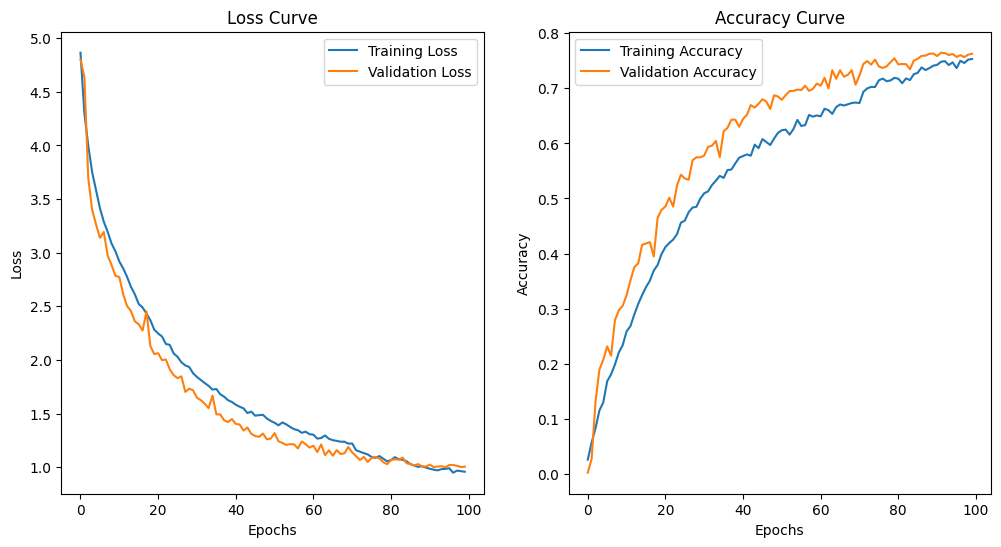

In [ ]:
plot_history(history_augm_CNN3 ,"model_CNN3_augm" )

**Loss**: the loss curves of this model are significantly better, compared to the previous models. The curves are very similar (with a very minimal divergence) and decrease smoothly over epochs. This suggests good learning and effective generalization of the model.

**Accuracy**: similar to the loss case, the accuracy curves increase constantly, with a minimal divergence and variance.
The accuracy scores indicate that the model has reached good performance, which can be still improved by increasing the number of training epochs

#### Confusion matrix

In [49]:
#model_CNN3 = tf.keras.models.load_model("model_CNN3_augm_oxford102.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━

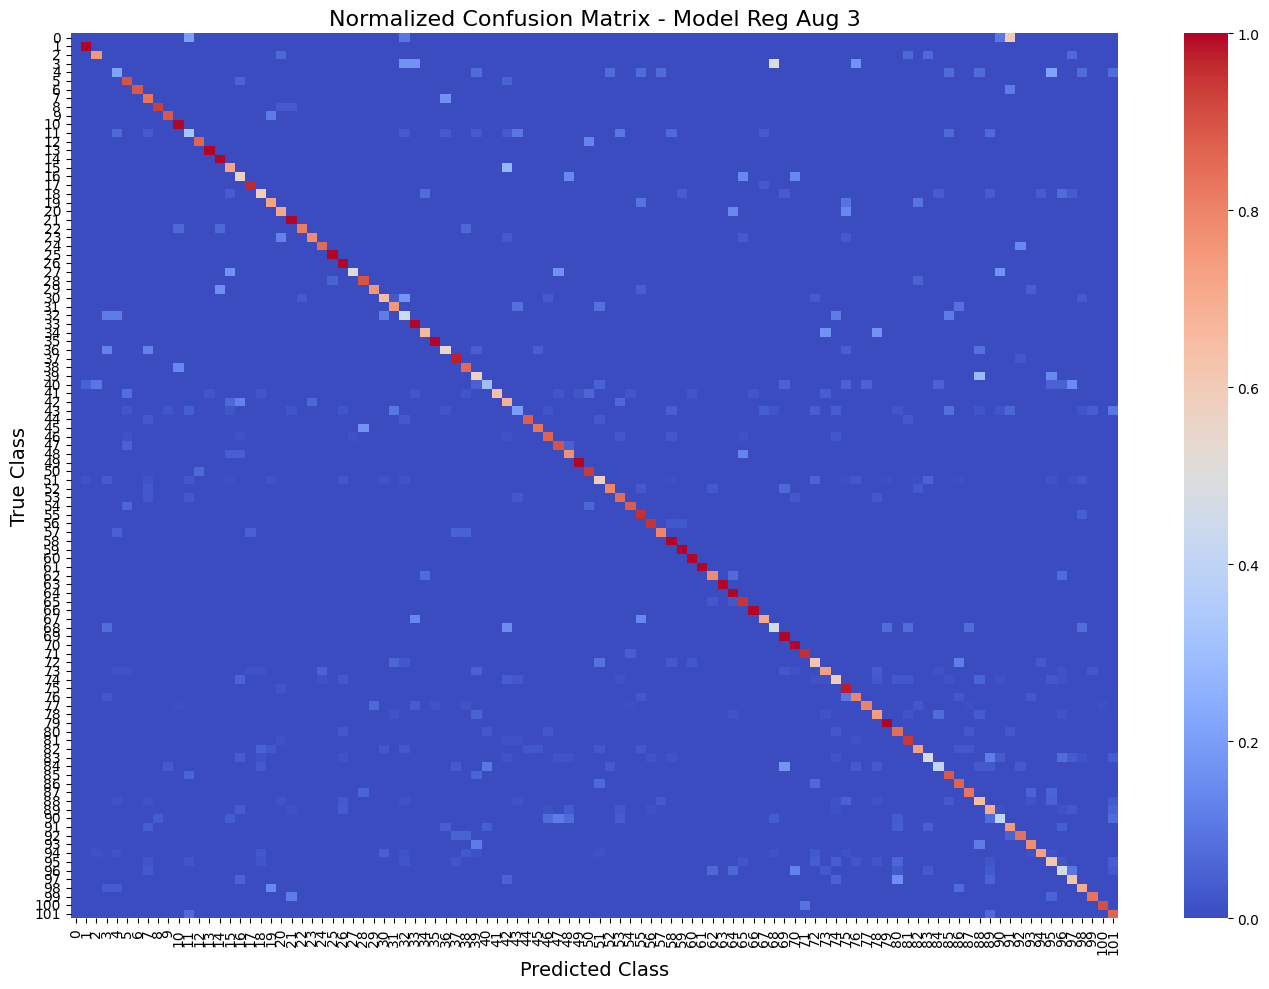

In [50]:
plot_cm(test_ds , model_CNN3)

#### Calculating accuracy on test set and balanced test set

In [ ]:
# Calculate the accuracy on test set
test_loss, test_accuracy = model_CNN3.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate the accuracy on the balanced test set
test_loss, test_accuracy = model_CNN3.evaluate(test_ds_equalsize)
print(f"Test Accuracy (balanced test-set): {test_accuracy * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.7575 - loss: 0.9812
Test Accuracy: 75.47%
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7651 - loss: 0.9138
Test Accuracy (balanced test-set): 77.45%


### CNN 3 without data augmentation

In [ ]:
def create_improved_flower_cnn_noDA(input_shape=(224, 224, 3), num_classes=102):
    """
    Improved CNN for flower classification:
    - Reduced parameters in Dense layers to prevent overfitting
    - Increased Dropout and L2 regularization
    - GlobalAveragePooling to reduce Flatten-related overfitting
    - Lower initial learning rate for finer weight updates
    """
    model_improved_noDA = models.Sequential([
        # First conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.DepthwiseConv2D((3, 3), activation='relu', padding='same',
                             depthwise_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),

        #Second conv block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.DepthwiseConv2D((3, 3), activation='relu', padding='same',
                             depthwise_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),

        # Third conv block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.DepthwiseConv2D((3, 3), activation='relu', padding='same',
                             depthwise_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),

        # Fourth conv block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.DepthwiseConv2D((3, 3), activation='relu', padding='same',
                             depthwise_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),

        # Global Average Pooling layer
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model with reduced learning rate
    model_improved_noDA .compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model_improved_noDA

# Updated callbacks

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        min_delta=0.0005
    )
]

In [ ]:
model_CNN3_noDA = create_improved_flower_cnn_noDA()
model_CNN3_noDA.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_4 (DepthwiseConv2D) │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_4                  │ (None, 112, 112, 32)        │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_5 (DepthwiseConv2D) │ (None, 112, 112, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_5                  │ (None, 56, 56, 64)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_6 (DepthwiseConv2D) │ (None, 56, 56, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 443,622 (1.69 MB)

 Trainable params: 441,446 (1.68 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:
history_CNN3_noDA = model_CNN3_noDA.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,  # Early stopping will prevent all epochs from running
    callbacks=callbacks_augm)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.0167 - loss: 5.0884 - val_accuracy: 0.0106 - val_loss: 4.7169 - learning_rate: 5.0000e-04
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.0303 - loss: 4.7184 - val_accuracy: 0.0061 - val_loss: 4.7665 - learning_rate: 5.0000e-04
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.0550 - loss: 4.4150 - val_accuracy: 0.0061 - val_loss: 4.8237 - learning_rate: 5.0000e-04
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.0605 - loss: 4.2122 - val_accuracy: 0.0023 - val_loss: 4.9235 - learning_rate: 5.0000e-04
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.0899 - loss: 4.0180 - val_accuracy: 0.0159 - val_loss: 4.9452 - learning_rate: 5.0000e-04
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.0940 - loss: 3.9111 - val_accuracy: 0.0500 - val_loss: 4.7044 - learning_rate: 5.0000e-04
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/ste

#### Saving the parameters of the trained model

In [ ]:
# Save the model
model_CNN3_noDA.save("model_CNN3noDA_oxford102.h5")

#### Plotting train and validation accuracy/loss

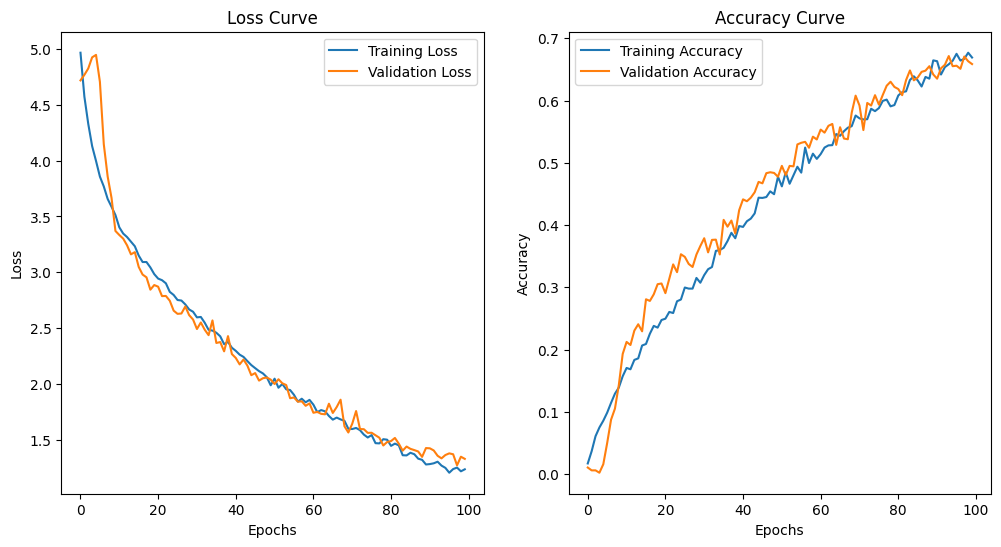

In [ ]:
plot_history(history_CNN3_noDA, "model_CNN3noDA")

**Loss**: the curves decrease constantly and with very low divergence. Compared to the loss of the previoud model, this appears to be slightly more unstable, with greater variation

**Accuracy**: The accuracy curves are very close to each other but show slightly more irregularities compared to the model with data augmentation. Nonetheless, they demonstrate good learning and generalization.

The accuracy score is close to 70% for both curves, indicating that this model also performs better with the data augmentation technique, achieving an improvement of almost 10%.

#### Confusion matrix

In [51]:
#model_CNN3_noDA = tf.keras.models.load_model("model_CNN3noDA_oxford102.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━

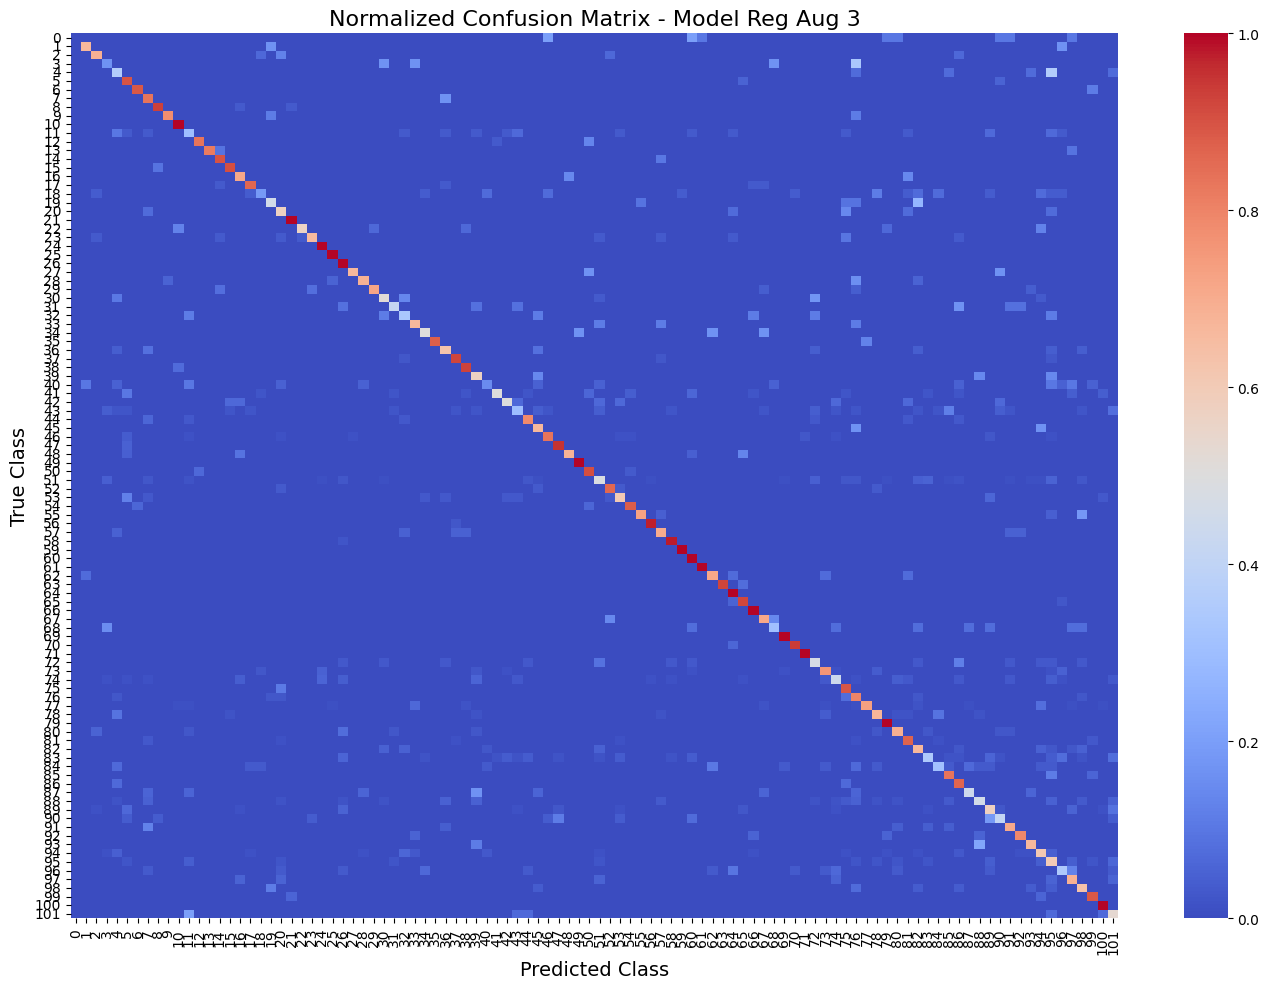

In [52]:
plot_cm(test_ds , model_CNN3_noDA)

#### Calculating accuracy on test set and balanced test set

In [ ]:
# Calculate the accuracy on test set
test_loss, test_accuracy = model_CNN3_noDA.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#Accuracy on balanced test set
test_loss, test_accuracy = model_CNN3_noDA.evaluate(test_ds_equalsize)
print(f"Test Accuracy on balanced test set: {test_accuracy * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.6920 - loss: 1.2700
Test Accuracy: 68.19%
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accuracy: 0.6973 - loss: 1.2461
Test Accuracy on balanced test set: 68.79%
